# super-resolution basic test
## CNN을 활용해서 subpxiel이라는 레이어를 만든 trick

### 활용하는 데이터 셋은 celeb A라는 유명인 데이터

## 1. 데이터 전처리과정

In [2]:
import os, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import pyramid_reduce 
plt.style.use('dark_background')

In [3]:
os.getcwd()

'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin'

In [4]:
base_path = 'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive'
img_base_path1 = os.path.join(base_path, 'img_align_celeba')
img_base_path = os.path.join(img_base_path1, 'img_align_celeba')
target_img_path = os.path.join(base_path, 'processed')

In [5]:
base_path

'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive'

In [6]:
eval_list = np.loadtxt(os.path.join(base_path, 'list_eval_partition.csv'), dtype=str, delimiter=',', skiprows=1)
## 'list_eval_partition.csv' 이 파일은 트레이닝, 테스트, 벨리데이션 셋 구분 해놓은 csv 파일
eval_list[0]

array(['000001.jpg', '0'], dtype='<U10')

(178, 178, 3) (177, 177, 3)


C:\Users\Bluemin\AppData\Local\Temp\ipykernel_11588\2530304097.py:6: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  resized_sample = pyramid_reduce(crop_sample, downscale=4, multichannel=True)  # 4배로 다운스케일을 시켜서 저해상도로 만들거임


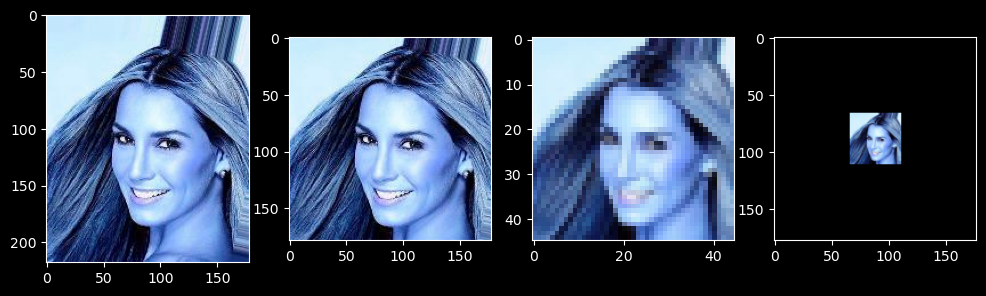

In [7]:
img_sample = cv2.imread(os.path.join(img_base_path, eval_list[0][0]))  

h, w, _ = img_sample.shape

crop_sample = img_sample[int((h-w)/2):int(-(h-w)/2), :]   # 세로로 긴 이미지를 정사각형으로 만드는 과정
resized_sample = pyramid_reduce(crop_sample, downscale=4, multichannel=True)  # 4배로 다운스케일을 시켜서 저해상도로 만들거임

pad = int((crop_sample.shape[0] - resized_sample.shape[0]) / 2)

padded_sample = cv2.copyMakeBorder(resized_sample, top=pad, bottom=pad, left=pad, right=pad, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

print(crop_sample.shape, padded_sample.shape)

plt.figure(figsize=(12, 5))
plt.subplot(1, 4, 1)
plt.imshow(img_sample)
plt.subplot(1, 4, 2)
plt.imshow(crop_sample)
plt.subplot(1, 4, 3)
plt.imshow(resized_sample)
plt.subplot(1, 4, 4)
plt.imshow(padded_sample)

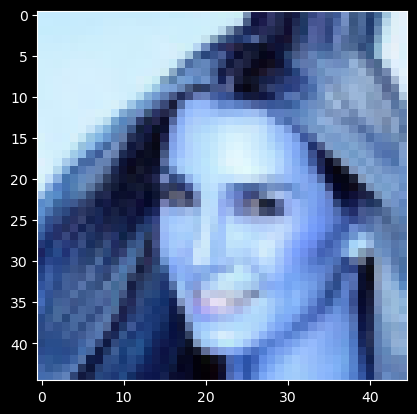

In [8]:
plt.imshow(resized_sample)

In [ ]:
downscale = 4
n_train = 162770
n_val = 19867
n_test = 19962

for i, e in enumerate(eval_list):
    filename, ext = os.path.splitext(e[0])
    
    img_path = os.path.join(img_base_path, e[0])
    
    img = cv2.imread(img_path)
    
    h, w, _ = img.shape
    
    crop = img[int((h-w)/2):int(-(h-w)/2), :]
    crop = cv2.resize(crop, dsize=(176, 176))
    resized = pyramid_reduce(crop, downscale=downscale, multichannel=True)  # 이미지를 1/4크기로 만듦 + 픽셀값 normalize(0~1)

    norm = cv2.normalize(crop.astype(np.float64), None, 0, 1, cv2.NORM_MINMAX)
    
    if int(e[1]) == 0:  # 데이터 셋 별로 폴더저장
        np.save(os.path.join(target_img_path, 'x_train', filename + '.npy'), resized)
        np.save(os.path.join(target_img_path, 'y_train', filename + '.npy'), norm)
    elif int(e[1]) == 1:
        np.save(os.path.join(target_img_path, 'x_val', filename + '.npy'), resized)
        np.save(os.path.join(target_img_path, 'y_val', filename + '.npy'), norm)
    elif int(e[1]) == 2:
        np.save(os.path.join(target_img_path, 'x_test', filename + '.npy'), resized)
        np.save(os.path.join(target_img_path, 'y_test', filename + '.npy'), norm)
 

C:\Users\Bluemin\AppData\Local\Temp\ipykernel_38160\3628282185.py:17: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  resized = pyramid_reduce(crop, downscale=downscale, multichannel=True)  # 이미지를 1/4크기로 만듦 + 픽셀값 normalize(0~1)


In [9]:
import cv2, os, glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Activation
from keras.layers import Conv2D, Input, Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from skimage.transform import pyramid_expand

from Subpixel import Subpixel
from DataGenerator import DataGenerator

In [10]:
data_path = 'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive\\processed'

x_train_list = sorted(glob.glob(os.path.join(data_path, 'x_train', '*.npy')))
x_val_list = sorted(glob.glob(os.path.join(data_path, 'x_val', '*.npy')))

x_train_list

print(len(x_train_list), len(x_val_list))
print(x_train_list[0])

162770 19867
C:\Users\Bluemin\2023\Image-Super-Resolution-Project\Youngmin\archive\processed\x_train\000001.npy


In [11]:
x_train_list

['C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive\\processed\\x_train\\000001.npy',
 'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive\\processed\\x_train\\000002.npy',
 'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive\\processed\\x_train\\000003.npy',
 'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive\\processed\\x_train\\000004.npy',
 'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive\\processed\\x_train\\000005.npy',
 'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive\\processed\\x_train\\000006.npy',
 'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive\\processed\\x_train\\000007.npy',
 'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive\\processed\\x_train\\000008.npy',
 'C:\\Users\\Bluemin\\2023\\Image-Super-Resolution-Project\\Youngmin\\archive\\processed\\x_train\\00000

(44, 44, 3) (44, 44, 3)


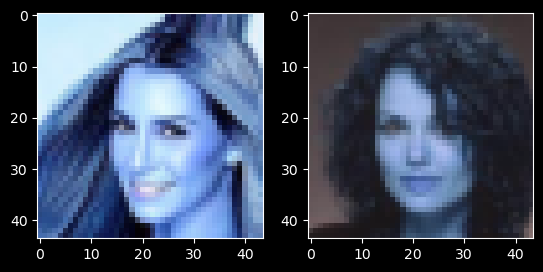

In [12]:
x1 = np.load(x_train_list[0])
x2 = np.load(x_val_list[0])

print(x1.shape, x2.shape)

plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.subplot(1, 2, 2)
plt.imshow(x2)

In [13]:
train_gen = DataGenerator(list_IDs=x_train_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=True)

val_gen = DataGenerator(list_IDs=x_val_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=False)

In [14]:
model.summary()

NameError: name 'model' is not defined

In [11]:
import tensorflow as tf

upscale_factor = 4

inputs = Input(shape=(44, 44, 3))

net = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
net = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=upscale_factor**2 * 3, kernel_size=3, strides=1, padding='same', activation='relu')(net)

# Apply depth to space operation to increase the channel dimension
net = tf.nn.depth_to_space(net, block_size=upscale_factor)

outputs = Activation('relu')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44, 44, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 44, 44, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 44, 48)        13872     
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, 176, 176, 3)      0         
 ambda)                                                          
                                                             

ImportError: cannot import name 'SubpixelConv2D' from 'tensorflow.keras.layers' (C:\Users\Bluemin\anaconda3\lib\site-packages\keras\api\_v2\keras\layers\__init__.py)

In [15]:
!pip install subpixel-conv2d

ERROR: Could not find a version that satisfies the requirement subpixel-conv2d (from versions: none)
ERROR: No matching distribution found for subpixel-conv2d


In [15]:
from tensorflow.keras.layers import UpSampling2D
from subpixel_conv2d import SubpixelConv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model

In [42]:
upscale_factor = 4

inputs = Input(shape=(44, 44, 3))

net = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
net = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=48, kernel_size=3, strides=1, padding='same', activation='relu')(net)
# net = UpSampling2D(upscale_factor)(net)

net = SubpixelConv2D(upsampling_factor=4)(net)

outputs = Activation('relu')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse')

In [41]:
16*3

48

In [43]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 44, 44, 3)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 44, 44, 64)        4864      
                                                                 
 conv2d_41 (Conv2D)          (None, 44, 44, 64)        36928     
                                                                 
 conv2d_42 (Conv2D)          (None, 44, 44, 32)        18464     
                                                                 
 conv2d_43 (Conv2D)          (None, 44, 44, 48)        13872     
                                                                 
 subpixel_conv2d_9 (Subpixel  (None, 176, 176, 3)      0         
 Conv2D)                                                         
                                                           

In [36]:
import tensorflow.keras.backend as K

In [37]:
K.int_shape(net)

(None, 176, 176, 1)

In [44]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 44, 44, 3)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 44, 44, 64)        4864      
                                                                 
 conv2d_41 (Conv2D)          (None, 44, 44, 64)        36928     
                                                                 
 conv2d_42 (Conv2D)          (None, 44, 44, 32)        18464     
                                                                 
 conv2d_43 (Conv2D)          (None, 44, 44, 48)        13872     
                                                                 
 subpixel_conv2d_9 (Subpixel  (None, 176, 176, 3)      0         
 Conv2D)                                                         
                                                           

In [47]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1, callbacks=[
ModelCheckpoint('models/model.h5', monitor='val_loss', verbose=1, save_best_only=True)
])

IndexError: list index out of range

In [48]:
len(train_gen), len(val_gen)

(10173, 1241)

In [86]:
upscale_factor = 4

inputs = Input(shape=(44, 44, 3))

net = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
net = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=upscale_factor**2, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Subpixel(filters=3, kernel_size=3, r=upscale_factor, padding='same')(net)
outputs = Activation('relu')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse')

model.summary()

ValueError: Exception encountered when calling layer "subpixel_16" (type Subpixel).

in user code:

    File "C:\Users\Bluemin\2023\Image-Super-Resolution-Project\Youngmin\Subpixel.py", line 75, in call  *
        return self._phase_shift(super(Subpixel, self).call(inputs))
    File "C:\Users\Bluemin\anaconda3\lib\site-packages\keras\layers\convolutional\base_conv.py", line 318, in call  **
        outputs.set_shape(out_shape)

    ValueError: Dimension 1 in both shapes must be equal, but are 44 and 176. Shapes are [?,44,44,48] and [?,176,176,3].


Call arguments received by layer "subpixel_16" (type Subpixel):
  • inputs=tf.Tensor(shape=(None, 44, 44, 16), dtype=float32)

In [ ]:
history = model.fit_generator(train_gen, validation_data=val_gen, epochs=10, verbose=1, callbacks=[
    ModelCheckpoint('models/model.h5', monitor='val_loss', verbose=1, save_best_only=True)
])

In [ ]:
x_test_list = sorted(glob.glob(os.path.join(base_path, 'x_test', '*.npy')))
y_test_list = sorted(glob.glob(os.path.join(base_path, 'y_test', '*.npy')))

print(len(x_test_list), len(y_test_list))
print(x_test_list[0])

In [ ]:
test_idx = 21

x1_test = np.load(x_test_list[test_idx])
x1_test_resized = pyramid_expand(x1_test, 4)
y1_test = np.load(y_test_list[test_idx])
y_pred = model.predict(x1_test.reshape((1, 44, 44, 3)))

print(x1_test.shape, y1_test.shape)

x1_test = (x1_test * 255).astype(np.uint8)
x1_test_resized = (x1_test_resized * 255).astype(np.uint8)
y1_test = (y1_test * 255).astype(np.uint8)
y_pred = np.clip(y_pred.reshape((176, 176, 3)), 0, 1)

x1_test = cv2.cvtColor(x1_test, cv2.COLOR_BGR2RGB)
x1_test_resized = cv2.cvtColor(x1_test_resized, cv2.COLOR_BGR2RGB)
y1_test = cv2.cvtColor(y1_test, cv2.COLOR_BGR2RGB)
y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(x1_test)
plt.subplot(1, 4, 2)
plt.title('resized')
plt.imshow(x1_test_resized)
plt.subplot(1, 4, 3)
plt.title('output')
plt.imshow(y_pred)
plt.subplot(1, 4, 4)
plt.title('groundtruth')
plt.imshow(y1_test)